## Rewrite of XPCS_SAXS notebook

In [1]:
import chx_analysis
import sparse
from tiled.client import from_profile
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({'image.origin': 'lower'})
plt.rcParams.update({'image.interpolation': 'none'})

/srv/conda/envs/notebook/lib/python3.9/site-packages/tiled/profiles.py:108: UserWarning: Skipping /nsls2/users/gbischof/.config/tiled/profiles/profiles. Failed to parse with error: IsADirectoryError(21, 'Is a directory').
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/tiled/profiles.py:108: UserWarning: Skipping /nsls2/users/gbischof/.config/tiled/profiles/tr, optional): the project that should contain this flow.. Failed to parse with error: ReaderError('<unicode string>', 0, 27, 'unicode', 'special characters are not allowed').
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/tiled/profiles.py:108: UserWarning: Skipping /nsls2/users/gbischof/.config/tiled/profiles/torage is built. Failed to parse with error: ReaderError('<unicode string>', 21, 8, 'unicode', 'special characters are not allowed').
  warnings.warn(
OBJECT CACHE: Will use up to 121_695_745_228 bytes (15% of total physical RAM)
OBJECT CACHE: Will use up to 121_695_745_228 bytes (

In [2]:
# Define the parameters.

export_path = '/nsls2/data/dssi/scratch/prefect-outputs/chx/compressed_data'
run_uid = 'e909f4a2-12e3-4521-a7a6-be2b728a826b'
tiled_client = from_profile("chx", username=None, api_key=None)
run = tiled_client[run_uid]
print(run)

OBJECT CACHE: Will use up to 121_695_745_228 bytes (15% of total physical RAM)


<BlueskyRun {'eiger4m_single_image_metadata_patched_in_at_runtime', 'primary'} scan_id=101172 uid='e909f4a2' 2022-07-18 15:25>


In [6]:
# Compose the run metadata.

metadata = chx_analysis.get_run_metadata(run)
metadata.update(chx_analysis.get_file_metadata(run))
print(metadata)

{'suid': 'e909f4a2', 'filename': '/nsls2/data/chx/legacy/data/2022/07/18/64d6bc55-2b1e-45eb-b5ba_1216_data_000020.h5', 'detector': 'eiger4m_single_image', 'eiger4m_single_cam_acquire_period': 0.002, 'eiger4m_single_cam_acquire_time': 0.001997, 'eiger4m_single_cam_num_images': 200, 'eiger4m_single_beam_center_x': 1143.0, 'eiger4m_single_beam_center_y': 1229.0, 'eiger4m_single_wavelength': 1.28507668359453, 'eiger4m_single_det_distance': 16.235550295, 'eiger4m_single_threshold_energy': 4824.0, 'eiger4m_single_photon_energy': 9648.0, 'eiger4m_single_stats1_bgd_width': 1, 'eiger4m_single_stats1_centroid_threshold': 1.0, 'eiger4m_single_stats1_compute_centroid': 'No', 'eiger4m_single_stats1_compute_histogram': 'No', 'eiger4m_single_stats1_compute_profiles': 'No', 'eiger4m_single_stats1_compute_statistics': 'Yes', 'eiger4m_single_stats1_hist_max': 255.0, 'eiger4m_single_stats1_hist_min': 0.0, 'eiger4m_single_stats1_hist_size': 256, 'eiger4m_single_stats1_ts_num_points': 2048, 'eiger4m_single

In [7]:
# Load the images.

images = run["primary"]["data"]["eiger4m_single_image"].read()
print(images)

dask.array<remote-dask-array-http://local-tiled-app/api/node/metadata/e909f4a2-12e3-4521-a7a6, shape=(1, 200, 2167, 2070), dtype=uint16, chunksize=(1, 10, 2167, 2070), chunktype=numpy.ndarray>


In [8]:
# Rotate the images if the detector is eiger500K_single_image.

print("detector_name:", metadata['detector'])
if metadata['detector'] =='eiger500K_single_image':    
    images = np.rotate(images, axis=(3,2))

print(images.shape, images.dtype)

detector_name: eiger4m_single_image
(1, 200, 2167, 2070) uint16


(2167, 2070) bool


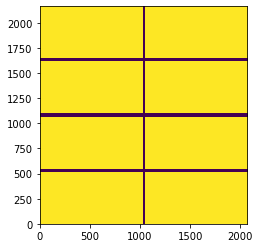

In [9]:
# Get the pixel mask.

pixel_mask =  chx_analysis.get_pixel_mask(metadata)
plt.imshow(pixel_mask)
print(pixel_mask.shape, pixel_mask.dtype)

eiger4m_single_image
(2167, 2070) bool


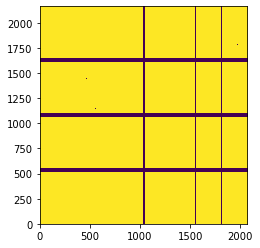

In [10]:
# Get the chip mask.

chip_mask = chx_analysis.get_chip_mask(metadata)
print(metadata['detector'])
plt.imshow(chip_mask)
print(chip_mask.shape, chip_mask.dtype)

(2167, 2070) bool


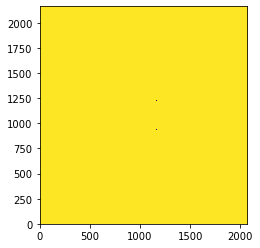

In [11]:
# Get the bad pixel mask.

bad_pixel_mask = chx_analysis.get_bad_pixel_mask(metadata)
plt.imshow(bad_pixel_mask)
print(bad_pixel_mask.shape, bad_pixel_mask.dtype)

(2167, 2070) bool


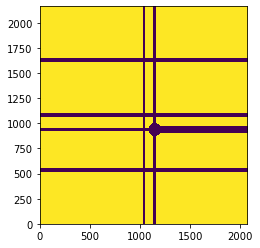

In [12]:
# Get the other mask.
# We need to think of a better name for this.

unknown_mask = chx_analysis.get_mask()
plt.imshow(unknown_mask)
print(unknown_mask.shape, unknown_mask.dtype)

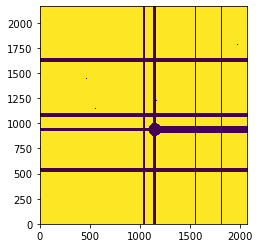

In [13]:
# Combine all of the masks.
# Note: SAXS may not use chip_mask.
final_mask = bad_pixel_mask & chip_mask & unknown_mask & pixel_mask
plt.imshow(final_mask)

In [14]:
%%time
# Apply the final mask to the images.

# Make the final mask the same shape as the images by extending the mask into a 3d array.
num_images = images.shape[1]
mask3d = np.broadcast_to(final_mask, (num_images,) + final_mask.shape)

# Flip the images to match mask orientation (TODO: probably better to flip the mask for faster computing).
flipped_images = np.flip(images, axis=2)

# Apply the mask to flipped images.
masked_images = flipped_images * mask3d

CPU times: user 3.7 s, sys: 894 ms, total: 4.59 s
Wall time: 4.9 s


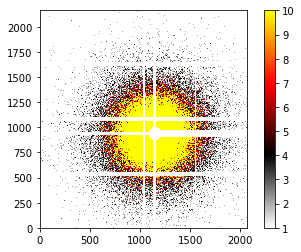

In [15]:
color_list_hdr_albula = [
    [255.0 / 255.0, 255.0 / 255.0, 255.0 / 255.0],
    [0.0 / 255.0, 0.0 / 255.0, 0.0 / 255.0],
    [255.0 / 255.0, 0.0 / 255.0, 0.0 / 255.0],
    [255.0 / 255.0, 255.0 / 255.0, 0.0 / 255.0],
    # [ 255.0/255.0, 255.0/255.0, 255.0/255.0],
]

cmap_hdr_albula = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap_hdr_albula", color_list_hdr_albula
)

plt.imshow(masked_images[0][40], vmin=1, vmax=10, cmap = cmap_hdr_albula)
plt.colorbar()

In [16]:
%%time
# Run sparsification
sparse_images = masked_images.map_blocks(sparse.COO).compute()

CPU times: user 1min 6s, sys: 35.9 s, total: 1min 42s
Wall time: 51 s


In [19]:
# Check sparse data matches CHX data
# Note: Maybe we should be sparisfying before applying the mask.

# Read CHX data using Multifile
fd = chx_analysis.Multifile(chx_analysis.run2_file_chx,0,200)

# Compare DAW sparse data to CHX data
np.array_equal(sparse_images[0][50].todense(),fd.rdframe(50).astype('uint16'))

True

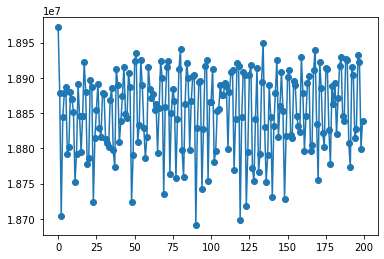

In [20]:
# Plot total intensity for each frame.
# We may need to use the image sum before the mask.

imgsum = [img.compute().sum() for img in masked_images[0]]
plt.scatter(list(range(200)), imgsum)
plt.plot(list(range(200)), imgsum)
plt.show()

In [22]:
# Removing bad frame.
# Remove average intensities that are outliers.
# Maybe skip the bad frame removal for now.
# The first 5 frames are usually ignored due to fast shutter timing, to make sure that the shutter is open.